# Monthly Average Time Series (Seasonal Cycle)

In [1]:
# Import modules
%run /g/data/w40/ri9247/code/aus_precip_benchmarking/master_functions_bmf.ipynb
import matplotlib as mpl
import os
import fnmatch
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

## Define Spatiotemporal boundaries and masks

In [3]:
# Define region of interest (lat and lon boundaries for all of Australia)
lat_slice = slice(-44.5,-10)
lon_slice = slice(112,156.25)
time_slice = slice("1976-01-01", "2005-12-30")

# Define temporal scale for SPI variable (1 for 3-months, 2 for 6-months, 3 for 12-months); use "None" if not using the SPI variable
iscale = None

# Define season as a list of month numbers. If not wanting a seasonal breakdown, use None.
# Suggestions: Wet 6-month: [10,11,12,1,2,3]; Dry 6-month: [4,5,6,7,8,9]; Wet 3-month: [12,1,2]; Dry 3-month: [6,7,8]
season = None 
season_name = 'Annual' 

# Paths to mask datasets
mask_ds = xr.open_dataset('/g/data/w40/ri9247/CORDEX-Australasia/data/obs/AUS-44i_grid/no_indices/mask/AUS-44i_combined_quality_mask.nc')

# Extract masks over Australia
mask = mask_ds.station_mask.sel(lat=lat_slice, lon=lon_slice)

## Define Keywords for Data

Keywords needed are bracketed {}. Model directories are set-up following: <br>
**Climpact Indices:** <br>
parent_directory/CORDEX-Australasia/data/{rcm-or-gcm}/{grid_type}/climpact/{historical-or-future}/{indice-keyword}/{yr-or-mon}/dataset_file.nc <br>
**Daily Data:** <br> 
parent_directory/CORDEX-Australasia/data/{rcm-or-gcm}/{grid_type}/no_indices/dataset_file.nc <br>
<br>
**Keyword Options:** <br>
model_type: 'rcm', 'gcm' <br>
GCM grid_type: 'coarsest_gcm_grid', 'native_grid' <br>
RCM grid_type: 'AUS-44i_grid', 'coarsest_gcm_grid', 'one_degree_gridgrid', 'native_grid' <br>
time_period: 'historical', 'future' <br>
variable: See list of Climpact Indices at: https://climpact-sci.org/indices; must be all-lowercase <br>
temporal_resolution: 'yr', 'mon'

## Using Climpact

In [4]:
# Define keywords to be used with f-strings to build the path to datasets
model_type = 'rcm'
grid_type = 'AUS-44i_grid'
time_period = 'historical'
variable = 'prcptot'
temporal_resolution = 'mon'
obs_temporal_resolution = 'MON'

# Define paths to data
master_path = '/g/data/w40/ri9247/CORDEX-Australasia/data/'
#frogs_master_path = '/g/data/ua8/Working/Climpact_FROGs/indices/'

model_data_path = master_path +  f"{model_type}/{grid_type}/climpact/{time_period}/{variable}/{temporal_resolution}/"
agcd_data_path = master_path + f"obs/{grid_type}/climpact/{variable}/{variable}_{obs_temporal_resolution}_agcd_historical_v1_1950-2020.nc"

## Get Pandas Dataframe with complete list of model dataset file paths

In [6]:
model_paths = get_model_files(model_data_path)

# Check that we're grabbing the correct files
pd.set_option('display.max_colwidth', None)
model_paths

rcm driving_gcm  \
0     RegCM4-7  MPI-ESM-MR   
1     RegCM4-7  HadGEM2-ES   
2      WRF360J     CanESM2   
3      WRF360K     CanESM2   
4     REMO2015  MPI-ESM-LR   
5     REMO2015  HadGEM2-ES   
6      WRF360K   ACCESS1-0   
7    CCAM-2008   ACCESS1-0   
8    CCAM-1704      MIROC5   
9     REMO2015   NorESM1-M   
10     WRF360J   ACCESS1-0   
11   CCAM-1704  GFDL-ESM2M   
12  CCLM5-0-15  HadGEM2-ES   
13   CCAM-2008   NorESM1-M   
14  CCLM5-0-15  MPI-ESM-LR   
15  CCLM5-0-15   NorESM1-M   
16   CCAM-2008      MIROC5   
17   CCAM-2008  GFDL-ESM2M   
18   CCAM-1704  HadGEM2-CC   
19   CCAM-1704    CNRM-CM5   
20    RegCM4-7   NorESM1-M   
21   CCAM-1704   NorESM1-M   
22   CCAM-1704   ACCESS1-0   
23   CCAM-2008     CanESM2   

                                                                                                                                                                                            dataset_path  
0           /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MPI-M-MPI-ESM-MR_historical_r1i1p1_ICTP-RegCM4-7_v0_day_19700101-20051231.nc  
1            /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MOHC-HadGEM2-ES_historical_r1i1p1_ICTP-RegCM4-7_v0_day_19700101-20051230.nc  
2               /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_CCCma-CanESM2_historical_r1i1p1_UNSW-WRF360J_v1_day_19510101-20051231.nc  
3               /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_CCCma-CanESM2_historical_r1i1p1_UNSW-WRF360K_v1_day_19510101-20051231.nc  
4         /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MPI-M-MPI-ESM-LR_historical_r1i1p1_GERICS-REMO2015_v1_day_19700101-20051231.nc  
5          /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MOHC-HadGEM2-ES_historical_r1i1p1_GERICS-REMO2015_v1_day_19700101-20051230.nc  
6         /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_CSIRO-BOM-ACCESS1-0_historical_r1i1p1_UNSW-WRF360K_v1_day_19510101-20051231.nc  
7      /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_CSIRO-BOM-ACCESS1-0_historical_r1i1p1_CSIRO-CCAM-2008_v1_day_19600101-20051231.nc  
8             /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MIROC-MIROC5_historical_r1i1p1_CSIRO-CCAM-1704_v1_day_19600101-20051231.nc  
9            /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_NCC-NorESM1-M_historical_r1i1p1_GERICS-REMO2015_v1_day_19700101-20051231.nc  
10        /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_CSIRO-BOM-ACCESS1-0_historical_r1i1p1_UNSW-WRF360J_v1_day_19510101-20051231.nc  
11    /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_NOAA-GFDL-GFDL-ESM2M_historical_r1i1p1_CSIRO-CCAM-1704_v1_day_19600101-20051231.nc  
12   /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MOHC-HadGEM2-ES_historical_r1i1p1_CLMcom-HZG-CCLM5-0-15_v1_day_19500101-20051230.nc  
13           /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_NCC-NorESM1-M_historical_r1i1p1_CSIRO-CCAM-2008_v1_day_19600101-20051231.nc  
14  /g/data/w40/ri9247/CORDEX-Australasia/data/rcm/AUS-44i_grid/climpact/historical/prcptot/mon/prcptot_MON_AUS-44i_MPI-M-MPI-ESM-LR_historical_r1i1p1_CLMcom-HZG-CCLM5-0-15_v1_day_19490101-20051231.nc  
15     /g/da

## Get Monthly Averages for Model Data and Store in Pandas Dataframe

In [8]:
# No unit conversion needed
data_type = "model_climpact"

rcm_master_timeseries_df = pd.DataFrame(columns=["month", f"{variable}", 'RCM_GCM_pair', "rcm", "driving_gcm"])

# Loop through models and get monthly averages
for i, row in model_paths.iterrows(): 
    
    # Get timeseries data
    timeseries_xr = get_monthly_averages(row[2], variable, time_slice, lat_slice, lon_slice, data_type, iscale, mask)

    # Convert the resulting xarray to a pandas df
    model_timeseries_df = timeseries_xr.to_dataframe()    
    
    # Add month column
    model_timeseries_df['month'] = model_timeseries_df.index
    model_timeseries_df['rcm'] = row[0]
    model_timeseries_df['driving_gcm'] = row[1]
    model_timeseries_df['RCM_GCM_pair'] = f'{row[0]} {row[1]}'
    
    # Append the master time series 
    rcm_master_timeseries_df = pd.concat([rcm_master_timeseries_df, model_timeseries_df])

# Sort the values based on the RCM-GCM and the month
rcm_master_timeseries_df = rcm_master_timeseries_df.sort_values(["RCM_GCM_pair", "month"], ascending=True) 

# Change the numerical month to the name of the month for a nicer plot below
rcm_master_timeseries_df['month'] = pd.to_datetime(rcm_master_timeseries_df['month'], format='%m').dt.month_name().str.slice(stop=3)
rcm_master_timeseries_df

month     prcptot         RCM_GCM_pair        rcm driving_gcm
1    Jan   92.282642  CCAM-1704 ACCESS1-0  CCAM-1704   ACCESS1-0
2    Feb  112.390534  CCAM-1704 ACCESS1-0  CCAM-1704   ACCESS1-0
3    Mar   88.179500  CCAM-1704 ACCESS1-0  CCAM-1704   ACCESS1-0
4    Apr   37.340111  CCAM-1704 ACCESS1-0  CCAM-1704   ACCESS1-0
5    May   25.373001  CCAM-1704 ACCESS1-0  CCAM-1704   ACCESS1-0
..   ...         ...                  ...        ...         ...
8    Aug   25.818050      WRF360K CanESM2    WRF360K     CanESM2
9    Sep   24.718062      WRF360K CanESM2    WRF360K     CanESM2
10   Oct   27.404883      WRF360K CanESM2    WRF360K     CanESM2
11   Nov   35.765463      WRF360K CanESM2    WRF360K     CanESM2
12   Dec   42.142622      WRF360K CanESM2    WRF360K     CanESM2

[288 rows x 5 columns]

## Use Pivot Table to reorganize dataframe for quick ranking table

In [12]:
rcm_mon_avg_piv = pd.pivot_table(rcm_master_timeseries_df, values=f'{variable}', index='RCM_GCM_pair', columns='month')
rcm_mon_avg_piv

month                        Apr        Aug         Dec         Feb  \
RCM_GCM_pair                                                          
CCAM-1704 ACCESS1-0    37.340111  22.369334   65.564154  112.390534   
CCAM-1704 CNRM-CM5     45.108955  21.765683   70.304042  110.464451   
CCAM-1704 GFDL-ESM2M   37.438352  23.862969   60.651259  112.224419   
CCAM-1704 HadGEM2-CC   34.023278  21.089108   63.200014  110.517478   
CCAM-1704 MIROC5       44.383735  19.661571   69.519838  106.554809   
CCAM-1704 NorESM1-M    41.562962  22.010587   65.172895  109.729458   
CCAM-2008 ACCESS1-0    40.230429  32.472718   84.494911   90.434102   
CCAM-2008 CanESM2      48.549635  33.905226   89.791648   91.894214   
CCAM-2008 GFDL-ESM2M   38.574855  26.767273   62.373212   87.177378   
CCAM-2008 MIROC5       38.166052  39.078017   79.614146  104.468207   
CCAM-2008 NorESM1-M    26.855941  20.049304   38.563229   67.193177   
CCLM5-0-15 HadGEM2-ES  37.165416  17.640229   53.734132   79.225353   
CCLM5-0-15 MPI-ESM-LR  25.315078  18.071598   52.516101   61.478120   
CCLM5-0-15 NorESM1-M   15.364634  19.906249   38.082545   40.026525   
REMO2015 HadGEM2-ES    44.224355  22.658952   63.495949  102.553320   
REMO2015 MPI-ESM-LR    35.296846  19.857242   59.975401   86.527970   
REMO2015 NorESM1-M     23.172953  21.414184   57.686804   67.262743   
RegCM4-7 HadGEM2-ES    72.398594  39.190296  104.670593  151.539900   
RegCM4-7 MPI-ESM-MR    41.391204  30.047011   69.184488   94.925233   
RegCM4-7 NorESM1-M     45.039527  34.913855   86.598251   78.431051   
WRF360J ACCESS1-0      59.991002  33.991955   76.625136  112.960269   
WRF360J CanESM2        48.168543  29.044973   65.179101   77.997985   
WRF360K ACCESS1-0      52.355183  39.045970   58.391568   83.581095   
WRF360K CanESM2        34.908657  25.818050   42.142622   48.680703   

month                         Jan        Jul        Jun         Mar  \
RCM_GCM_pair                                                          
CCAM-1704 ACCESS1-0     92.282642  24.285179  23.862752   88.179500   
CCAM-1704 CNRM-CM5      94.944787  24.263554  23.815545   86.640973   
CCAM-1704 GFDL-ESM2M    92.613770  25.098756  24.446408   84.032203   
CCAM-1704 HadGEM2-CC    97.181867  23.471328  19.783393   76.580100   
CCAM-1704 MIROC5       109.794640  26.433394  25.610333   91.871282   
CCAM-1704 NorESM1-M     98.448061  25.127834  27.019427   87.961847   
CCAM-2008 ACCESS1-0     82.213344  27.974604  29.121067   68.416699   
CCAM-2008 CanESM2      104.249269  35.127651  34.913161   72.665325   
CCAM-2008 GFDL-ESM2M    92.583526  27.976291  34.776345   75.731072   
CCAM-2008 MIROC5        98.943635  40.871363  40.300158   66.572891   
CCAM-2008 NorESM1-M     72.571613  21.801880  19.182436   63.065653   
CCLM5-0-15 HadGEM2-ES   72.495320  17.599670  24.632491   61.950752   
CCLM5-0-15 MPI-ESM-LR   61.481586  21.443258  24.790939   46.792906   
CCLM5-0-15 NorESM1-M    50.375353  15.671193  15.357401   27.575880   
REMO2015 HadGEM2-ES     88.489091  24.744539  28.652191   81.846980   
REMO2015 MPI-ESM-LR     92.282367  23.799951  28.270063   67.131363   
REMO2015 NorESM1-M      88.079028  19.978600  16.916424   44.696856   
RegCM4-7 HadGEM2-ES    129.105763  41.528547  51.676356  123.722126   
RegCM4-7 MPI-ESM-MR    101.388627  38.908287  46.662632   84.463346   
RegCM4-7 NorESM1-M     101.880270  31.457786  32.868115   71.882670   
WRF360J ACCESS1-0      105.703803  27.460493  30.079896   84.226933   
WRF360J CanESM2         86.858893  32.150987  31.362968   67.586833   
WRF360K ACCESS1-0       72.074654  35.138542  39.805793   64.907769   
WRF360K CanESM2         56.697465  28.437373  30.107426   44.352700   

month                        May        Nov        Oct        Sep  
RCM_GCM_pair                                                       
CCAM-1704 ACCESS1-0    25.373001  45.347016  32.299094  17.682957  
CCAM-1704 CNRM-CM5     24.971574  53.550967  30.473740  17.613501  
CCAM-1704 GFDL-ESM2M   26.429848  

## Get Monthly Averages for Observational Datasets

#### AGCD

In [14]:
# No unit conversion needed
data_type = "obs"

# Get Monthly averages for AGCD dataset
agcd_monthly_avg = get_monthly_averages(agcd_data_path, variable, time_slice, lat_slice, lon_slice, data_type, iscale, mask)
agcd_monthly_avg_df = agcd_monthly_avg.to_dataframe()
agcd_monthly_avg_df['month'] = model_timeseries_df.index
agcd_monthly_avg_df['month'] = pd.to_datetime(agcd_monthly_avg_df['month'], format='%m').dt.month_name().str.slice(stop=3)
agcd_monthly_avg_df

prcptot month
month                 
1      81.059230   Jan
2      85.923450   Feb
3      57.643868   Mar
4      30.533358   Apr
5      31.022017   May
6      27.420951   Jun
7      26.295073   Jul
8      21.436948   Aug
9      19.244696   Sep
10     26.551663   Oct
11     37.076753   Nov
12     57.669987   Dec

## Set-up Plotting Specifications

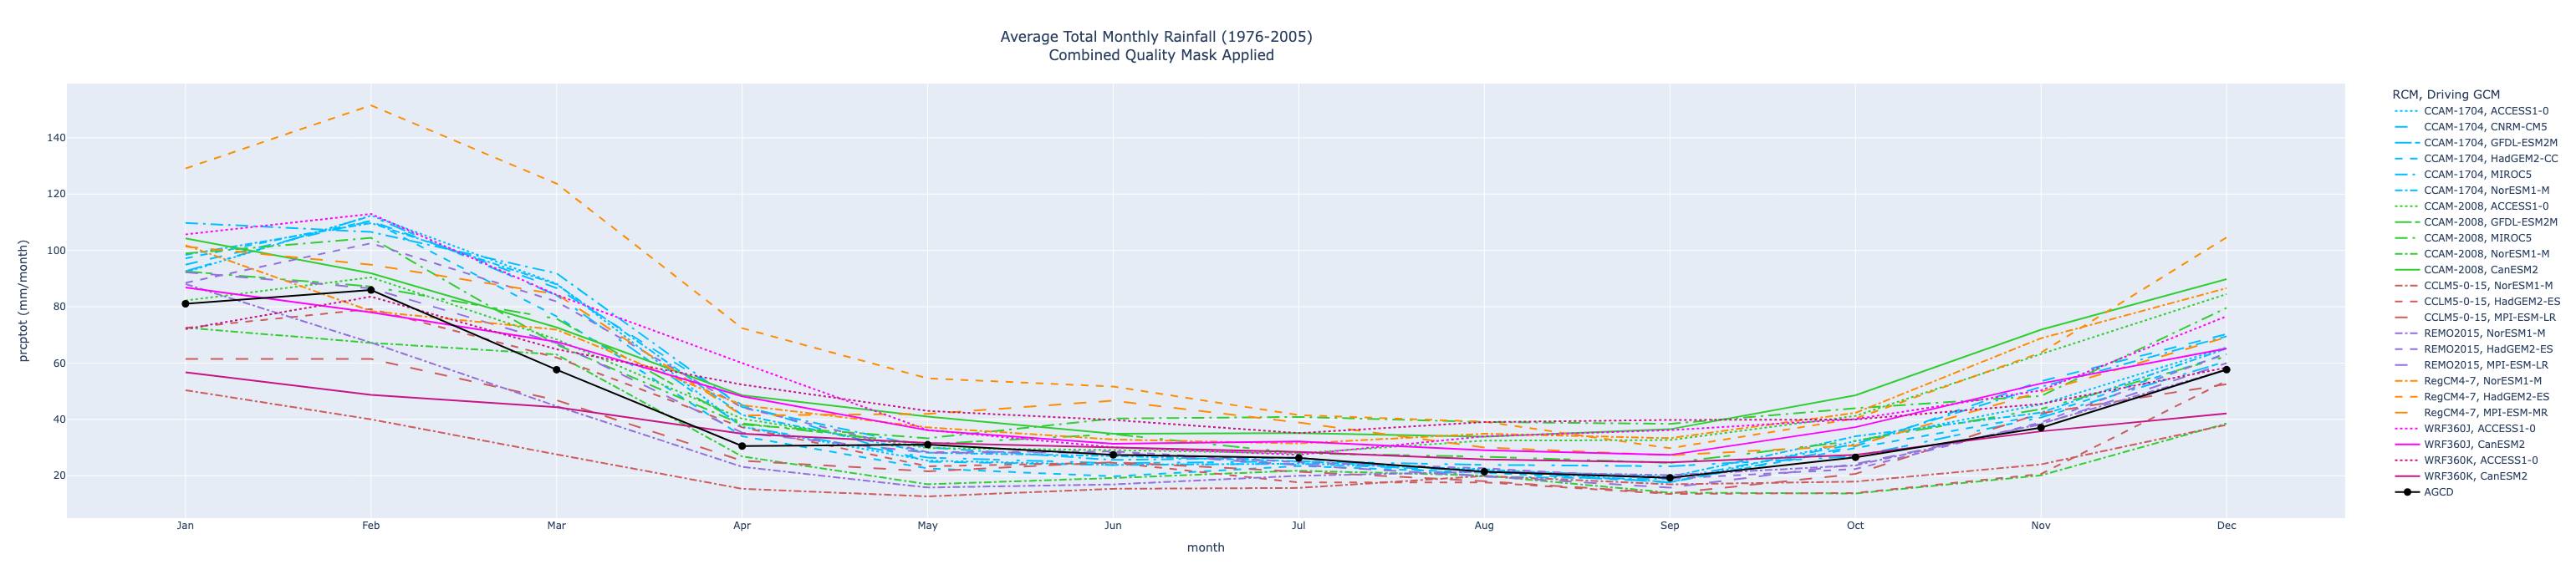

In [15]:
# Define line styles based on GCM and colors based on RCM
gcm_lines = {'NorESM1-M':'dashdot',
             'CNRM-CM5':'longdash',
             'CanESM2':'solid',
             'ACCESS1-0':'dot',
             'HadGEM2-ES':'dash',
             'MPI-ESM-LR':'longdash',
             'HadGEM2-CC':'dash',
             'GFDL-ESM2M':'20px,4px,8px',
             'MIROC5':'longdashdot',
             'MPI-ESM-MR':'longdash'
             }

rcm_colors = {'CCAM-1704':'deepskyblue',
             'CCAM-2008':'limegreen',
             'WRF360J':'magenta',
             'WRF360K':'mediumvioletred',
             'CCLM5-0-15':'indianred',
             'REMO2015':'mediumpurple',
             'RegCM4-7':'darkorange'}


ts_fig = px.line(rcm_master_timeseries_df, x=rcm_master_timeseries_df['month'], y=f"{variable}", line_dash='driving_gcm', line_dash_map=gcm_lines, color='rcm', color_discrete_map=rcm_colors,
                 hover_data=['rcm', 'driving_gcm', f"{variable}"], width=1080, height=700,
    labels={
         "rcm": "RCM",
         "driving_gcm": "Driving GCM",
         f"{variable}": f"{variable}" " (mm/month)",
         "index": "Month",
     },
    title= "Average Total Monthly Rainfall (1976-2005) <br> Combined Quality Mask Applied")

ts_fig.update_traces(marker={'size': 8})

# Add Observations 
ts_fig.add_trace(go.Scatter(
    x=agcd_monthly_avg_df['month'], y=agcd_monthly_avg_df[f"{variable}"],
    line_color='rgb(0,0,0)',
    name='AGCD',
    hovertemplate = 'AGCD: %{y:.2f}mm<br>Month: %{x}<extra></extra>',
    marker={'size': 9}

))

ts_fig.update_layout(title_x=0.45)

ts_fig.show()